## Lecture outline
- Iterative methods to compute centralities
- Network flows

## Summary on centralities
**Degree centrality**: the centrality of a node is proportional to its (in)degree. 
$$
z_i = w_i
$$

**Eigenvector centrality**: it takes into account that connections to more central nodes are more important.

$$
z = \frac{W'z}{\lambda_W}
$$

**Invariant distribution centrality**: it generalizes the eigenvector centrality by taking into account the relative weight of connections.

$$
z = P'z
$$

**Katz centrality**: it generalizes the eigenvector centrality by assuming that nodes have also an intrinsic centrality. The centrality is the sum of the intrinsic centrality and the centrality given by the network.

$$
z =  \frac{1-\beta}{\lambda_W} W' z + \beta \mu 
$$

**Bonacich centrality (or Page-rank)**: it generalizes the invariant distribution centrality by assuming that nodes have also an intrinsic centrality. The centrality is the sum of the intrinsic centrality and the centrality given by the network.
$$ 
z = (1-\beta)P' z + \beta \mu 
$$

There are many ways to compute Katz and Bonacich centralities: **direct** and **iterative**.
In the last lecture we have seen two ways:
- by using NetworkX functions
- by inverting the formula (direct method)

### Direct method
Direct methods consist in inverting the equation above and computing directly the centrality. Notice that

1. the Katz centrality 
$ z =  (\mathbf{I}-\frac{1-\beta}{\lambda_W} W')^{-1} \beta \mu $

2. and Bonacich centrality 
$ z = (\mathbf{I}-(1-\beta)P')^{-1} \beta \mu $

Note that the inversion can be done because the matrices $\frac{1-\beta}{\lambda_W} W'$ and $(1-\beta)P'$ have spectral radius less than 1


In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

G = nx.karate_club_graph()

# compute matrices of the graph
W = nx.adjacency_matrix(G)
W = W.toarray()
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

# Iterative methods
<mark>The smartest way to compute Bonacich centrality (or Katz centrality) is to by iterative methods.</mark>

Consider the dynamics
$$
\begin{cases} 
z(t+1) = (1-\beta)P'z(t) + \beta \mu  \\
z(0) = z_0
\end{cases}
$$

The transient of the dynamics is

$$
\begin{cases}
z(1) = (1-\beta)P'z(0) + \beta \mu\\
z(2) = (1-\beta)^2 (P')^2 z(0) + (1-\beta)P' \beta \mu + \beta \mu\\
\vdots\\
z(t) = (1-\beta)^t (P')^t z(0) + \sum_{i=0}^{t-1} (1-\beta)^i (P')^i \beta \mu
\end{cases}
$$

The first term vanishes as $t \to +\infty$ because $(1-\beta)P'$ is sub-stochastic, while the second is a geometric sum. The dynamics thus converges to the limit

$$
\lim_{t \to +\infty} z(t) = (\mathbf{I}-(1-\beta) P')^{-1} \beta \mu,
$$

which is the Bonacich centrality of the graph.

**Remark 1**: You should never use direct ways to compute centralities if iterative algorithms are available. The iterative method is more efficient than the direct one as the order of the graph grows, since it does not involve the inversion of a matrix $N \times N$.

**Remark 2**: Note that the convergence of $z(t)$ to the Bonacich centrality holds for every initial condition $z_0$ and the limit is independent of $z_0$.

**Remark 3**: Notice that the proposed method is **distributed**, i.e., the operations at single node levels do not require a complete knowledge of the network. Each node $i$ updates its state $z_i(t+1)$ by using only local information, i.e., the i-th row of $W$ and the state $z_j(t)$ of nodes $j$ that are adjacent to $j$.

Let us implement the distributed method.

In [2]:
N = G.number_of_nodes()
beta = 0.15
mu = np.ones((N,1))/N

# arbitrary initial condition: 1/N-uniform vector of size N (initial condition does not matters)
z_0 = np.ones((N,1))/N

# set a tolerance to assess convergence to the limit
tol = 1e-5

# run the dynamics
z_old = z_0

while True:
    z_new = P.T @ z_old * (1-beta) + beta * mu
    if np.linalg.norm(z_new-z_old) < tol:   # it converges to the limit 
        break
    z_old=z_new

zb_distr = z_new

# normalize the centrality
zb_distr = zb_distr / sum(zb_distr)

print("Bonacich centrality: \n", zb_distr)

Bonacich centrality: 
 [[0.09700182]
 [0.05287839]
 [0.05707842]
 [0.03586064]
 [0.02197941]
 [0.02911334]
 [0.02911334]
 [0.02449076]
 [0.02976534]
 [0.01430895]
 [0.02197941]
 [0.00956492]
 [0.01464519]
 [0.02953631]
 [0.01453516]
 [0.01453516]
 [0.01678538]
 [0.01455886]
 [0.01453516]
 [0.01960442]
 [0.01453516]
 [0.01455886]
 [0.01453516]
 [0.03152092]
 [0.02107546]
 [0.02100563]
 [0.0150434 ]
 [0.0256388 ]
 [0.01957296]
 [0.02628726]
 [0.02458934]
 [0.03715664]
 [0.07169213]
 [0.10091792]]


## Katz centrality

For Katz centrality, consider the following dynamics:

$$
\begin{cases} 
z(t+1) = \frac{(1-\beta)}{\lambda_W}W'z(t) + \beta \mu  \\
z(0) = z_0.
\end{cases}
$$

It is easy to prove that the dynamics converges to the Katz centrality.

**Remark**: notice that the proposed method is iterative (and therefore more efficient than direct method), but it is not distributed. Indeed, to perform the computation, every node needs to know $\lambda_W$, which is a global information on the network.

## Exercise
Compute the Katz centrality of the Zachary's karate club graph by iterative methods, and compare the results with direct methods.

**Hint**: use the definition of Katz centrality and same techniques as above

In [3]:
W = nx.adjacency_matrix(G)
W = W.toarray()

# compute the largest eigenvalue of W
w,v = np.linalg.eig(W)
w = w.real

lambda_max = max(w) 

beta = 0.15
mu = np.ones((N,1))

z_0 = np.ones((N,1))/N
# set a tolerance to assess convergence to the limit
tol = 1e-5
# evolve the dynamics
z_old = z_0

while True:
    z_new = W.T @ z_old * (1-beta)/lambda_max + beta * mu
    if np.linalg.norm(z_new-z_old) < tol:
        break
    z_old=z_new

zk_approx = z_new

# normalize the centrality
zk_approx = zk_approx / sum(zk_approx)

print("Katz centrality: \n", zk_approx)

Katz centrality: 
 [[0.06577067]
 [0.04811348]
 [0.05603656]
 [0.03881773]
 [0.01903498]
 [0.02041214]
 [0.02041214]
 [0.03211799]
 [0.04104375]
 [0.02145814]
 [0.01903498]
 [0.01404963]
 [0.01895544]
 [0.0407567 ]
 [0.02150751]
 [0.02150751]
 [0.01089689]
 [0.02013024]
 [0.02150751]
 [0.02876895]
 [0.02150751]
 [0.02013024]
 [0.02150751]
 [0.03051402]
 [0.01595495]
 [0.01631209]
 [0.01786708]
 [0.02733092]
 [0.02615997]
 [0.02762194]
 [0.03277526]
 [0.0372037 ]
 [0.0564272 ]
 [0.06835471]]


In [4]:
zk_iterative = zk_approx

#direct method (previous notebook)
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W
N = G.number_of_nodes() 
beta = 0.15
mu = np.ones((N,1))
w,v = np.linalg.eig(W)
w = w.real
lambda_max = max(w) 
zk = np.linalg.inv(np.diag(np.ones(N)) - W.T*(1-beta)/lambda_max) * beta @ mu
zk = zk/sum(zk)
zk_direct = zk

#comparison
zk_iterative = zk_iterative.reshape(N)
zk_direct = zk_direct.reshape(N)
print("Distance between zk_iterative and zk_direct:", np.linalg.norm(zk_iterative-zk_direct))

Distance between zk_iterative and zk_direct: 2.2256465889510023e-07


# Testing sensitivity of measures
In this section we will check the dependence of centrality measures with respect to their paramenters and the sensitivity of the iterative algorithms to compute such measure with respect to the number of iterations.

## The effect of parameters
In our first experiment we analyze the dependence of Page Rank centrality on the parameter $\alpha=1-\beta$. We set distinct values for $\alpha$ while we fix the number of iterations, and run Page Rank. Then we plot the resulting Page Rank values with respect to $\alpha$.

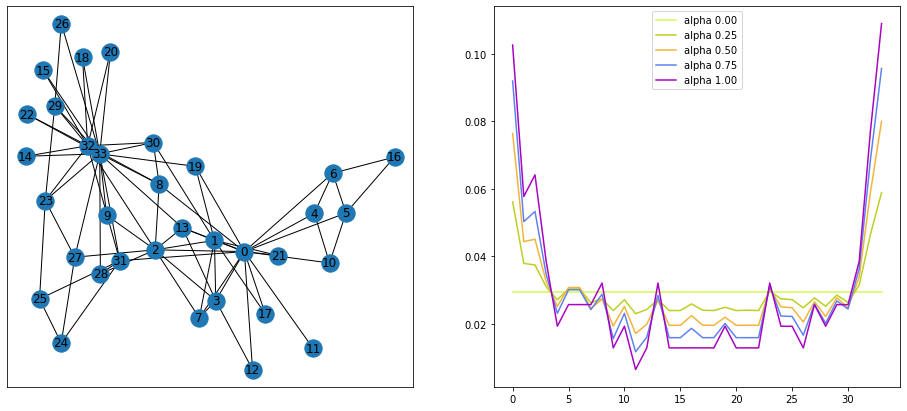

In [5]:
fig = plt.figure(2, figsize=(16,7))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

pos = nx.spring_layout(G) 
nx.draw_networkx(G, pos, ax=ax1)

# we consider values for alpha from 0 to 1 with step size 0.25
alphas = np.arange(0, 1.25, 0.25)

for alp in alphas:
    # pagerank has parameters alpha and mu:
    # note that alpha = 1-beta and weight parameters mu are set to 1 by default
    pr = nx.pagerank(G, alpha=alp) 
    prval = list(pr.values())
    ax2.plot(prval, color=np.random.rand(3), label='alpha {0:.2f}'.format(alp))
    
ax2.legend()

Let's explain the previous result. Keep in mind that the parameter alpha used by `nx.pagerank` corresponds to $1-\beta$, and the centrality $z$ satisfies

$$
z = (1-\beta)P'z + \beta \mu
$$

- As $\alpha = 0$ ($\beta = 1$), $z = \mu$, i.e., Bonacich is equivalent to the intrinsic centrality $\mu$, the network does not play any role.

- As $\alpha = 1$ ($\beta = 0$), $z = P'z$, i.e., Bonacich is equivalent to invariant distribution centrality (the intrinsic centrality is irrelevant).

In between these two extreme cases there is a combination of network effects and intrinsic centrality.

## Exercise ##
Repeat the analysis. This time keep $\alpha$ fixed to 0.5 and select 3 different non-uniform vectors $\mu$ as `personalization` parameter to `pagerank`. How do you interpret the result?

mu1
{0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25, 4: 0.25, 5: 0.25, 6: 0.25, 7: 0.25, 8: 0.5, 9: 0.5, 10: 0.5, 11: 0.5, 12: 0.5, 13: 0.5, 14: 0.5, 15: 0.5, 16: 0.5, 17: 0.75, 18: 0.75, 19: 0.75, 20: 0.75, 21: 0.75, 22: 0.75, 23: 0.75, 24: 0.75, 25: 1.0, 26: 1.0, 27: 1.0, 28: 1.0, 29: 1.0, 30: 1.0, 31: 1.0, 32: 1.0, 33: 1.0}
mu2
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 0.75, 9: 0.75, 10: 0.75, 11: 0.75, 12: 0.75, 13: 0.75, 14: 0.75, 15: 0.75, 16: 0.75, 17: 0.5, 18: 0.5, 19: 0.5, 20: 0.5, 21: 0.5, 22: 0.5, 23: 0.5, 24: 0.5, 25: 0.25, 26: 0.25, 27: 0.25, 28: 0.25, 29: 0.25, 30: 0.25, 31: 0.25, 32: 0.25, 33: 0.25}
mu3
{0: 0.35, 1: 0.35, 2: 0.35, 3: 0.35, 4: 0.35, 5: 0.35, 6: 0.35, 7: 0.35, 8: 0.45, 9: 0.45, 10: 0.45, 11: 0.45, 12: 0.45, 13: 0.45, 14: 0.45, 15: 0.45, 16: 0.45, 17: 0.55, 18: 0.55, 19: 0.55, 20: 0.55, 21: 0.55, 22: 0.55, 23: 0.55, 24: 0.55, 25: 0.55, 26: 0.55, 27: 0.55, 28: 0.55, 29: 0.55, 30: 0.55, 31: 0.55, 32: 0.55, 33: 0.55}


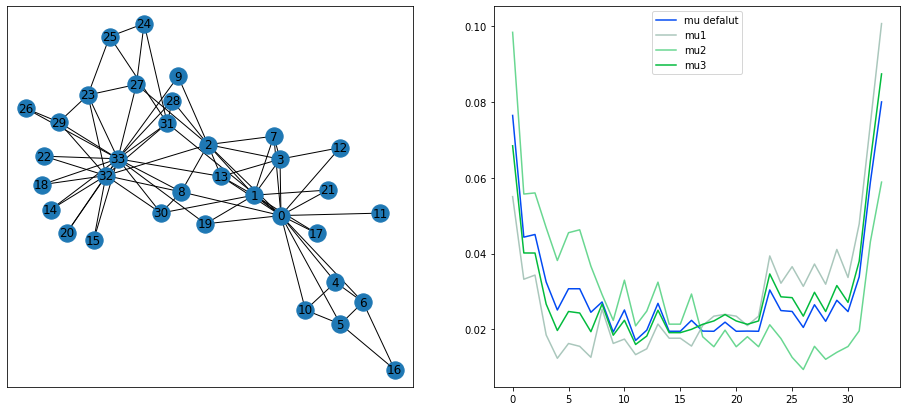

In [6]:
fig = plt.figure(2, figsize=(16,7))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

pos = nx.spring_layout(G) 
nx.draw_networkx(G, pos, ax=ax1)

alpha = 0.5

pr = nx.pagerank(G, alpha=alpha) 
prval = list(pr.values())
ax2.plot(prval, color=np.random.rand(3), label='mu defalut')
    
mu1 = np.ones(N)
mu1[0:int(N/4)] = 0.25
mu1[int(N/4):int(N/2)] = 0.5
mu1[int(N/2):int(3*N/4)] = 0.75
mu1[int(3*N/4):] = 1
iterat = zip(G.nodes(), list(mu1))
mu1_dict = dict(iterat)

mu2 = np.ones(N)
mu2[0:int(N/4)] = 1
mu2[int(N/4):int(N/2)] = 0.75
mu2[int(N/2):int(3*N/4)] = 0.5
mu2[int(3*N/4):] = 0.25
iterat = zip(G.nodes(), list(mu2))
mu2_dict = dict(iterat)

mu3 = np.ones(N)
mu3[0:int(N/4)] = 0.35
mu3[int(N/4):int(N/2)] = 0.45
mu3[int(N/2):int(3*N/4)] = 0.55
mu3[int(3*N/4):] = 0.55
iterat = zip(G.nodes(), list(mu3))
mu3_dict = dict(iterat)

mus = (mu1_dict, mu2_dict, mu3_dict)


for i, m in enumerate(mus):
    print(f"mu{i+1}")
    print(m)
    pr = nx.pagerank(G, alpha=alpha, personalization=m) 
    prval = list(pr.values())
    ax2.plot(prval, color=np.random.rand(3), label=f"mu{i+1}")
    
ax2.legend()

$\alpha$ = 0.5, 3 different non-uniform vectors $\mu$. $\mu1$ sorted in ascending order, $\mu2$ sorted in descending order, $\mu3$ sorted in ascending order with less differences between values.
Nodes with higher intrinsic centrality have higher values than the default case, proportional to $\mu$.


## The effect of iteration number
In this section we consider a bigger network and we analyse the speed of convergence of iterative algorithms for computing centrality measures. 
 

Download the political blogs network (save it as a .gml file in the working directory of this notebook) and import it as a Graph object. We check the basic properties of G

In [7]:
G = nx.read_gml('polblogs.gml')
print("Type of G:", type(G))

Type of G: <class 'networkx.classes.multidigraph.MultiDiGraph'>


Since G is a multigraph, we define an equivalent graph to compute the centralities (the function 'pagerank' does not work with multigraphs)

In [8]:
GG = nx.Graph()
for n, nbrs in G.adjacency(): 
    # edict is a dictionary of dictionaries; 
    # the keys of edict are parallel edges from n to nbr;
    # the values of edict are dictionary,
    # containing attribute values of the corresponding edge
    for nbr, edict in nbrs.items(): 
        # each edge has weight=1, so total value is just  
        # the number of parallel edges
        total_value = len(edict) 
        GG.add_edge(n, nbr, weight = total_value)

The graph is very large, thus we cannot plot it.

In [9]:
print(GG.number_of_nodes())

1224


We now test the convergence speed of `nx.pagerank` algorithm:

Errors: [0.0, 0.0, 0.0]


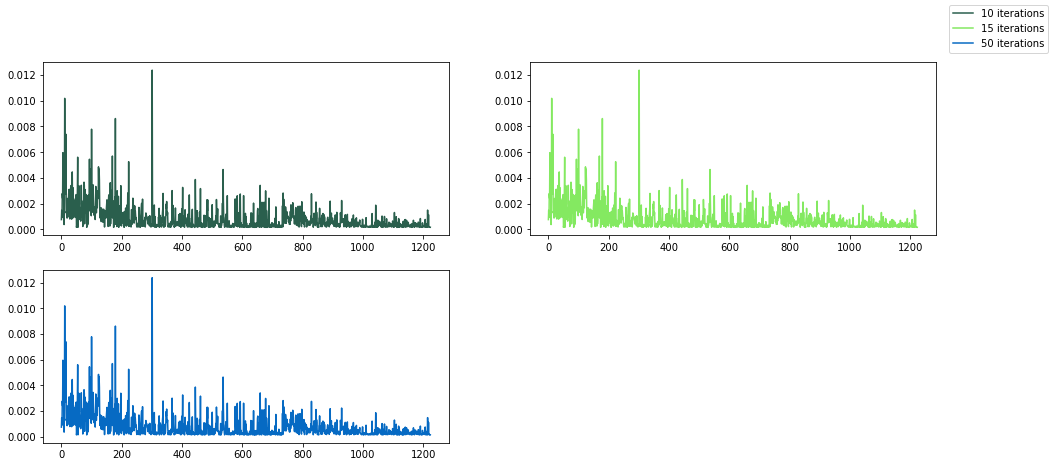

In [10]:
fig = plt.figure(1, figsize=(16,7))

# set 3 iteration numbers
iters = [10,15,50]
# define the position of the next plot in the subplot grid
position = 1
# create a list to collect the page rank values obtained in the three runs 
prvals = []

for max_iter in iters:
    # compute page rank
    pr = nx.pagerank(GG, max_iter = max_iter) 
    # compute page rank values
    prval = list(pr.values())
    # append the result to the list
    prvals.append(np.array(prval)) 
    # create a new sublot in the grid
    ax = fig.add_subplot(2,2,position)
    # plot the PR values
    ax.plot(prval, color=np.random.rand(3), label='{0:d} iterations'.format(max_iter))
    position+=1

# add a legend which contains all label
# informations specified in previous plot calls
fig.legend()  
# we assume the values obtained with nx.pagerank()
# with no iterations constraints as a benchmark
benchmark = np.array(list(nx.pagerank(GG).values())) 
# we compute errors as norm of the differences wrt the benchmark
errors = [np.linalg.norm(prval-benchmark) for prval in prvals]
print("Errors:", errors)

`nx.pagerank` algorithm converges very fast, in 10 iterations! 

### Exercise
Check if our iterative algorithm for computing Bonacich centrality is as good as this by performing a similar analysis.

Errors: [3.773390275950324e-05, 1.0895845752939813e-05, 2.6371866015138547e-05]


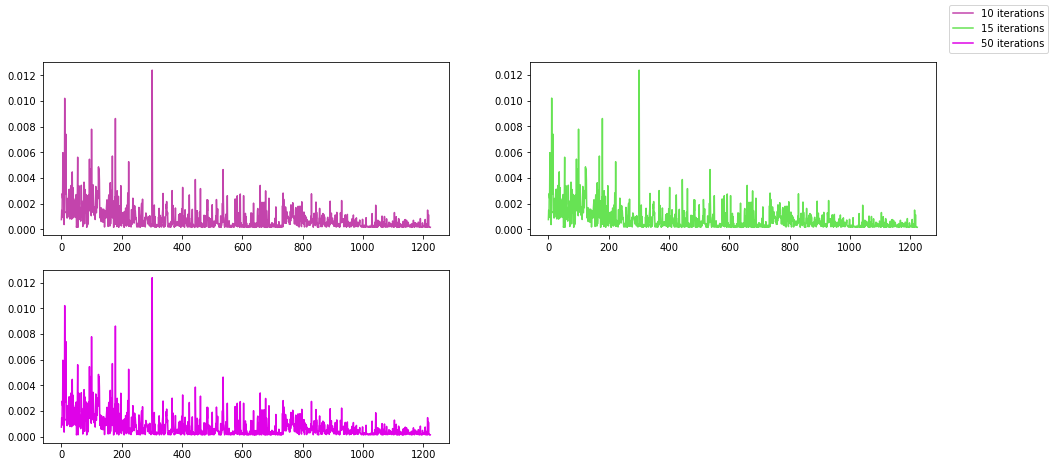

In [11]:
# compute matrices of the graph
WW = nx.adjacency_matrix(GG)
WW = WW.toarray()
ddegrees = np.sum(WW,axis=1)
DD = np.diag(ddegrees)
PP = np.linalg.inv(DD) @ WW

N = GG.number_of_nodes()
beta = 0.15
mu = np.ones((N,1))/N

# set a tolerance to assess convergence to the limit
tol = 1e-5


fig = plt.figure(1, figsize=(16,7))

# set 3 iteration numbers
iters = [10,15,50]
# define the position of the next plot in the subplot grid
position = 1
# create a list to collect the page rank values obtained in the three runs 
prvals = []

for max_iter in iters:
    # compute page rank
    z_0 = np.ones((N,1))/N
    z_old = z_0
    
    it = 1
    while True:
        z_new = PP.T @ z_old * (1-beta) + beta * mu
        if it > max_iter:
            break
        z_old=z_new
        it+=1

    pr = z_new

    # normalize the centrality
    prval = pr / sum(pr)
    
    # append the result to the list
    prvals.append(np.array(prval)) 
    # create a new sublot in the grid
    ax = fig.add_subplot(2,2,position)
    # plot the PR values
    ax.plot(prval, color=np.random.rand(3), label='{0:d} iterations'.format(max_iter))
    position+=1

# add a legend which contains all label
# informations specified in previous plot calls
fig.legend()
# we assume the values obtained with previous algortitm using 'tol'
# constraints as a benchmark
z_0 = np.ones((N,1))/N
z_old = z_0 
while True:
    z_new = PP.T @ z_old * (1-beta) + beta * mu
    if np.linalg.norm(z_new-z_old) < tol:
        break
    z_old=z_new
pr = z_new
# normalize the centrality
prval = pr / sum(pr)
benchmark = np.array(prval) 

# we compute errors as norm of the differences wrt the benchmark
errors = [np.linalg.norm(prval-benchmark) for prval in prvals]
print("Errors:", errors)

## An interpretation of Katz (and Bonacich) centrality
<mark>Bonacich centrality (as well as Katz centrality) can be interpreted in terms of paths on the graphs.</mark>
We show this by an example.

We shall make use of an undirected graph and Katz centrality to simplify the analysis.

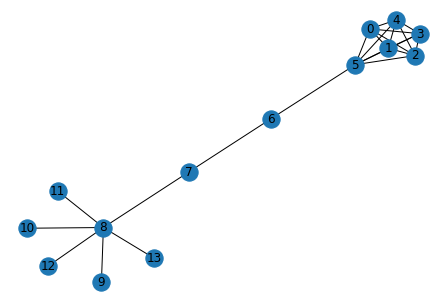

In [12]:
G = nx.lollipop_graph(6,3)
G.add_edges_from([(9,8),(10,8),(11,8),(12,8),(13,8)])

pos = nx.spring_layout(G) 
nx.draw(G, pos, with_labels = True)

N = len(G)

# compute matrices of the graph
W = nx.adjacency_matrix(G)
W = W.toarray()
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

# compute the largest eigenvalue of W
w,v = np.linalg.eig(W)
w = w.real

lambda_max = max(w) 

We start with a uniform centrality distribution $z_0$, and consider uniform $\mu$.

In [13]:
mu = np.ones((N,1))
beta = 0.15
# initial centrality distribution
z = np.ones((N,1))/N
z_reshape = z.reshape(N)

print("Centralities at iteration 0:", z_reshape)

Centralities at iteration 0: [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857]


Note that normalizing $\mu$ does not modify the centrality, since in

$$ 
z =  (\mathbf{I}-\frac{1-\beta}{\lambda_W} W')^{-1} \beta \mu 
$$

$\mu$ affects the normalization of $z$ only (same argument holds for the Bonacich centrality). 

However, the normalization of $\mu$ affects the transient of the iteration to compute $z$. In particular, if one considers the Bonacich centrality, using $\mu, z_0$ such that $\mathbf{1}' \mu = \mathbf{1}' z_0 = 1$ is preferable, since it guarantees that, if $\mathbf{1}' z(0)=1$, then $\mathbf{1}' z(t)=1$ for every $t$. Indeed, if $z(t-1) \mathbf{1}'= 1$, then 

$$
\mathbf{1}' z(t) = (1-\beta) \mathbf{1}' P' z(t-1) + \beta \mathbf{1}'\mu = (1-\beta) \mathbf{1}' z(t-1) + \beta = (1-\beta) + \beta = 1
$$

### Back to Katz centrality

After 1 iteration,
$$
z(1) = \frac{(1-\beta)}{\lambda_W}W'z(0) + \beta \mu,
$$

which means that the centrality of a node is the a combination of its intrinsic centrality, and the centrality of the neighbors. Since the intrinsic centrality is the same for every node, if we start with a uniform $z(0)$, $z(1)$ depends only on the degree of the node.

Similar observation can be made for the Bonacich centrality.

Centralities at iteration 1: [0.21028569 0.21028569 0.21028569 0.21028569 0.21028569 0.22234283
 0.17411428 0.17411428 0.22234283 0.16205714 0.16205714 0.16205714
 0.16205714 0.16205714]


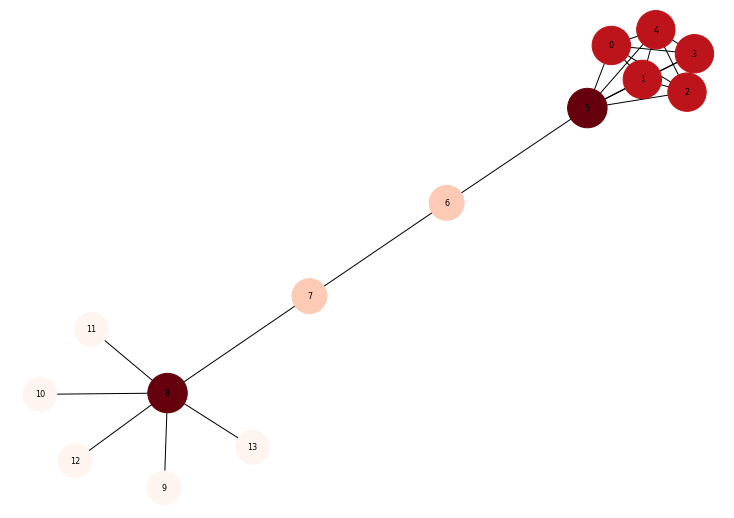

In [14]:
# after 1 iteration
z = W.T @ z * (1-beta)/lambda_max + beta * mu

z_reshape = z.reshape(N)

nodesize=z_reshape*7000

# plot centrality at iteration 0
plt.figure(1, figsize=(10,7))
# we draw the graph with same node position "pos" defined above
nx.draw(G,pos,
         with_labels=True,
         nodelist=list(G.nodes()), 
         # node size is proportional to centrality value
         node_size = nodesize, 
         # node's color reflects centrality values (higher dc = darker color)
         node_color=z_reshape,
         font_size=8,
         # node's colors are on the red scale
         cmap=plt.cm.Reds) 

print("Centralities at iteration 1:", z_reshape)

As the number of iteration grows, $z(n)$ takes into account also nodes at greater distance.

At the equilibrium, the centrality $z^*$ can be interpreted in terms of paths as follows:

\begin{equation}
\begin{aligned}
z^*&=\lim_{n \to +\infty}z(n)=\sum_{n = 0}^{\infty} \left(\frac{(1-\beta)}{\lambda_W}\right)^n (W')^n \beta \mu \\
   &= \beta \mu + \frac{(1-\beta)}{\lambda_W} (W') \beta \mu + \left(\frac{(1-\beta)}{\lambda_W}\right)^2 (W')^2 \beta \mu + \cdots
\end{aligned}
\end{equation}

If one considers node $i$

$$
z^*_i = \beta \mu_i + \frac{(1-\beta)}{\lambda_W}\beta \sum_{j} (W')_{ij} \mu_j + \left(\frac{(1-\beta)}{\lambda_W}\right)^2 \beta \sum_{j} ((W')^2)_{ij} \mu_j + \cdots
$$

**Interpretation**. Since $((W')^n)_{ij}$ is the number of paths of length $n$ from $j$ to $i$, the centrality of node $i$ is the sum of:
- its intrinsic centrality $\mu_i$, plus 
- the intrinsic centrality of its in-neighbors, i.e., $\sum_j W_{ji} \mu_j$, plus 
- the intrinsic centrality of the nodes connected by paths of length 2, and so on... 

Longer paths have a decreasing weight due to the term $(1-\beta)^n$.

**Question**: which node do you expect to have a higher Katz centrality? Why?


[0.12326521 0.12326521 0.12326521 0.12326521 0.12326521 0.12986511
 0.04569492 0.03352131 0.04555519 0.02580748 0.02580748 0.02580748
 0.02580748 0.02580748]


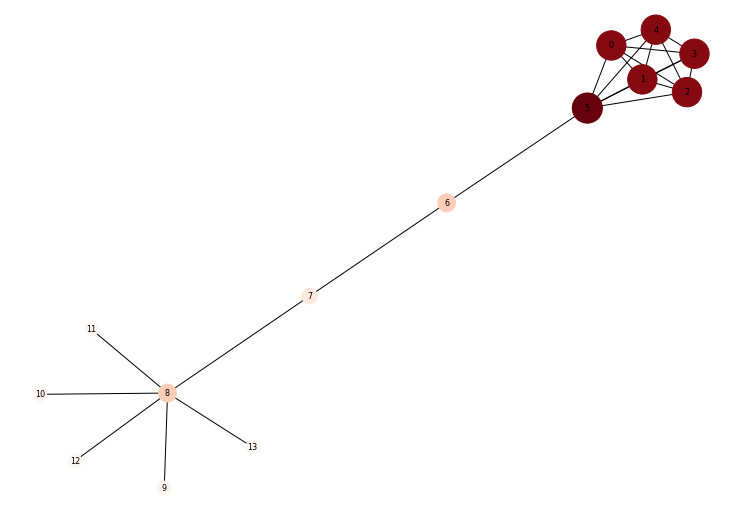

In [15]:
# set a tolerance to assess convergence to the limit
tol = 1e-5

z_0 = np.ones(N,)/N
mu = np.ones(N,)/N  #normalization (see before)

# run the dynamics
z_old = z_0
print()
while True:
    z_new = W.T @ z_old * (1-beta)/lambda_max + beta * mu
    if np.linalg.norm(z_new-z_old) < tol:
        break
    z_old=z_new

zk = z_new

# normalize the centrality
zk = zk/sum(zk)
zk = zk.reshape(N)

print(zk)

plt.figure(1, figsize=(10,7))
# we draw the graph with same node position "pos" defined above
nx.draw(G,pos,
         with_labels=True,
         nodelist=list(G.nodes()), 
         # node size is proportional to centrality value
         node_size = zk*7000, 
         # node's color reflects centrality values (higher dc = darker color)
         node_color=zk,
         font_size=8,
         # node's colors are on the red scale
         cmap=plt.cm.Reds) 

Nodes 8 and 5 are connected to the same number of nodes by path of length 1. Node 5 is connects to an higher number of nodes by path of length 2,3 with respect to node 8.

**Question**: how do you expect to be modified the centralities when using Bonacich instead of Katz? Focus on node 8.

**Hint**: recall the definition of the two centralities, i.e.,

- Katz: $z =  \frac{1-\beta}{\lambda_W} W' z + \beta \mu$
- Bonacich: $x = (1-\beta)P' x + \beta \mu$ 

[0.12326521 0.12326521 0.12326521 0.12326521 0.12326521 0.12986511
 0.04569492 0.03352131 0.04555519 0.02580748 0.02580748 0.02580748
 0.02580748 0.02580748]


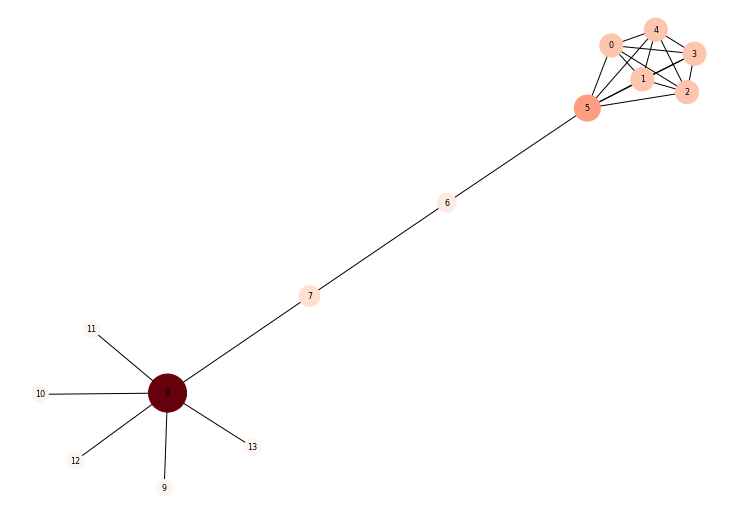

In [16]:
zb_dict = nx.algorithms.link_analysis.pagerank_alg.pagerank(G)

# check if the centrality are normalized
zb = np.array(list(zb_dict.values()))

print(zk)

plt.figure(1, figsize=(10,7))
# we draw the graph with same node position "pos" defined above
nx.draw(G,pos,
         with_labels=True,
         nodelist=list(G.nodes()), 
         # node size is proportional to centrality value
         node_size = zb*7000, 
         # node's color reflects centrality values (higher dc = darker color)
         node_color=zb,
         font_size=8,
         # node's colors are on the red scale
         cmap=plt.cm.Reds) 

The Bonacich takes into account the relative weight of connections. Node 8 is connected to nodes with lower degree py a path of lenght 1 with respect to those conncected to node 5.

## Exercise

Compute all the centralities for the this graph, plot them, and comment the results.

**Hint**: use the code introduced in the lectures to compute the degree, eigenvector, Katz and Bonacich centralities. For the invariant distribution centrality use the function `np.linalg.eig()` to find the invariant distribution of $P$. Use the code introduced in the last lecture to plot the centralities.

In [17]:
# TO DO

# Flows on graphs
In this lab we discuss how maximum admissible flows on a capacitated network are related with cuts in the network by the Max Flow - Min Cut theorem. 

Let us start with the definition of flows from a source 's' to a destination 't' (called terminal nodes).

**Definition**: a s-t flow is a distribution such that:
- for every non-terminal node the incoming flow equals the outcoming flow (mass conservation);
- the outcoming flow from $s$ equals the incoming flow to $t$ (this quantity is called **throughput**).

### Example
The blue edge labels indicate the flow along the edge.

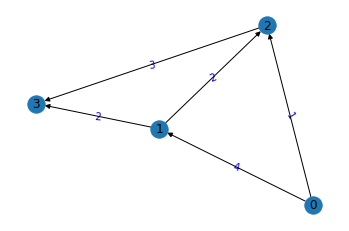

In [18]:
G = nx.DiGraph()
G.add_edges_from([(0,1),(0,2),(1,2),(2,3),(1,3)])

pos = nx.spring_layout(G)

# script to draw edge labels
nx.draw_networkx_edge_labels(G,pos,edge_labels={(0,1):'4',
(0,2):'1',(1,2):'2',(1,3):'2',
(2,3):'3'},font_color='blue')

nx.draw(G, pos, with_labels = True)

Observe that the flow distribution labelled in blue is a flow from 0 to 3. Indeed,
- for the non-terminal nodes 1 and 2, the incoming flow equals the outcoming flow;
- the total flow outcoming from 0 equals the total flow incoming to 3 (the throughput is 5).

## Max Flow - Min Cut Theorem
It is given a graph $G = (V, E)$ which represents a flow network and two vertices source $s$ and sink $t$ in it. Every edge $(u,v)$ has a capacity $c(u,v)$. We want to find the maximum possible flow from s to t with the following constraint:

1. Flow on an edge doesn’t exceed the given capacity of the edge.

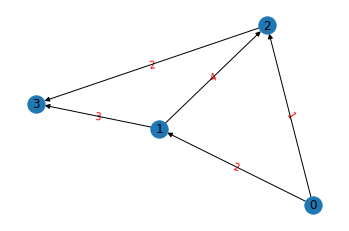

In [19]:
nx.draw_networkx_edge_labels(G,pos,edge_labels={(0,1):'2',
(0,2):'1',(1,2):'4',(1,3):'3',
(2,3):'2'},font_color='red')

nx.draw(G, pos, with_labels = True)

**Question**: consider the graph above with terminal nodes 0 and 3, where the red labels denote the capacity of the edge, i.e., the maximal flow that can be sent along the edge. What is the maximal flow that can be send from 0 to 3?

**Question**: give an intuitive answer on why a flow of throughput 4 cannot be sent.

**Definition (cut of a network)**: a s-t cut of the network $G=(N,E)$ is a partition of the nodes $\{U,U^C\}$, such that $s \in U$ and $t \in U_C$.

We shall see that the notion of cut is strongly related to the maximal flow that can be sent in the network. The cuts of the network above are:
- $U=\{0,1,2\},U^C=\{3\}$
- $U=\{0,1\},U^C=\{2,3\}$
- $U=\{0,2\},U^C=\{1,3\}$
- $U=\{0\},U^C=\{1,2,3\}$

**Definition (cut capacity)**: the capacity of a cut $\{U,U^C\}$ is
$$
C_{U} = \sum_{i \in U}\sum_{j \in U^C} c(i,j)
$$

**Max flow min cut Theorem**: the maximal flow that can send from $s$ to $t$ equals the minimal cut capacity among the s-t cuts of the network. 

**Back to the question**:
- $U=\{0,1,2\},U^C=\{3\}$ -> $C_U = 5$
- $U=\{0,1\},U^C=\{2,3\}$ -> $C_U = 8$
- $U=\{0,2\},U^C=\{1,3\}$ -> $C_U = 4$
- $U=\{0\},U^C=\{1,2,3\}$ -> $C_U = 3$

**Answer**: the 0-3 min-cut has capacity 3, thus the maximal flow from 0 to 3 is 3.

NetworkX has many functions useful for flow applications, e.g., `networkx.algorithms.flow.maximum_flow` and `networkx.algorithms.flow.minimum_cut`, which compute the maximum throughput and the value and the node partition of a minimum cut, respectively.

In [20]:
# to find the maximal flow, the edges have to be labelled with a 'capacity' label
# we then modify the graph in such a way to include this information 
# (check the `networkx.algorithms.flow.maximum_flow` documentation for more info)

G[0][1]['capacity'] = 2
G[0][2]['capacity'] = 1
G[1][2]['capacity'] = 4
G[1][3]['capacity'] = 3
G[2][3]['capacity'] = 2

nx.algorithms.flow.maximum_flow(G,0,3)

# maximum_flow returns the maximal throughput, plus a dictionary containing the value of the flow that goes through each edge.

(3, {0: {1: 2, 2: 1}, 1: {2: 0, 3: 2}, 2: {3: 1}, 3: {}})

In [21]:
nx.algorithms.flow.minimum_cut(G,0,3)

# minimum_cut returns the minimal cut capacity and the node partition of a minimum cut

(3, ({0}, {1, 2, 3}))

## <mark>Intervention in capacitated networks: two dual problems</mark>

### <mark>Adversarial intervention</mark>
**Question**: suppose you are an adversarial agent that aims at minimizing the flow that can be send from 0 to 3 by removing capacity subject to a budget constraint (or even disconnect the network). 
- Where do you remove the capacity? 
- What is the minimal capacity that you need to remove in order to disconnect the network?

**Answer** 
- Since the bottleneck of the flow is the min-cut of the network, the adversary should reduce the capacity of such a  cut. Thus, in this case, the adversary should reduce capacity of edges between the sets $\{0\}$ and the set $\{1,2,3\}$, which are $(0,1)$ and $(0,2)$. 
- The minimal capacity that needs to be removed equals the capacity of the min-cut of the network, which is 3.

While for this network the answer could be obvious, when the network is large the algorithms `networkx.algorithms.flow.maximum_flow` and `networkx.algorithms.flow.minimum_cut` are very useful!

Maximum flow: (3, {0: {1: 2, 2: 1}, 1: {2: 0, 3: 2}, 2: {3: 1}, 3: {}})
Minimum cut: (3, ({0}, {1, 2, 3}))


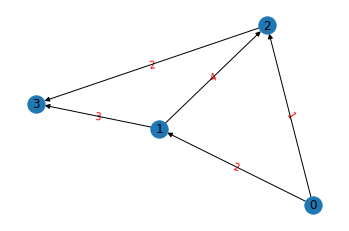

In [22]:
nx.draw_networkx_edge_labels(G,pos,edge_labels={(0,1):'2',
(0,2):'1',(1,2):'4',(1,3):'3',
(2,3):'2'},font_color='red')

nx.draw(G, pos, with_labels = True)

print("Maximum flow:", nx.algorithms.flow.maximum_flow(G,0,3))
print("Minimum cut:", nx.algorithms.flow.minimum_cut(G,0,3))

**Cuts**
- $U=\{0,1,2\},U^C=\{3\}$ -> $C_U = 5$
- $U=\{0,1\},U^C=\{2,3\}$ -> $C_U = 8$
- $U=\{0,2\},U^C=\{1,3\}$ -> $C_U = 4$
- $U=\{0\},U^C=\{1,2,3\}$ -> $C_U = 3$

In [23]:
print("Capacity of (0,1)", G[0][1])
print("Capacity of (0,2)", G[0][2])
G[0][1]['capacity'] -= 1 #capacity of (0,1) is decreased by 1
print("Capacity of (0,1)", G[0][1])
print("Capacity of (0,2)", G[0][2])
print("Maximum flow:", nx.algorithms.flow.maximum_flow(G,0,3))
print("Minimum cut:", nx.algorithms.flow.minimum_cut(G,0,3))

Capacity of (0,1) {'capacity': 2}
Capacity of (0,2) {'capacity': 1}
Capacity of (0,1) {'capacity': 1}
Capacity of (0,2) {'capacity': 1}
Maximum flow: (2, {0: {1: 1, 2: 1}, 1: {2: 0, 3: 1}, 2: {3: 1}, 3: {}})
Minimum cut: (2, ({0}, {1, 2, 3}))


Max flow is reduced by 1.

In [24]:
print("Capacity of (0,1)", G[0][1])
print("Capacity of (0,2)", G[0][2])
G[0][1]['capacity'] -= 1 #capacity of (0,1) is decreased by 1
print("Capacity of (0,1)", G[0][1])
print("Capacity of (0,2)", G[0][2])
print("Maximum flow:", nx.algorithms.flow.maximum_flow(G,0,3))
print("Minimum cut:", nx.algorithms.flow.minimum_cut(G,0,3))

Capacity of (0,1) {'capacity': 1}
Capacity of (0,2) {'capacity': 1}
Capacity of (0,1) {'capacity': 0}
Capacity of (0,2) {'capacity': 1}
Maximum flow: (1, {0: {1: 0, 2: 1}, 1: {2: 0, 3: 0}, 2: {3: 1}, 3: {}})
Minimum cut: (1, ({0}, {1, 2, 3}))


Max flow is reduced by 1.

In [25]:
print("Capacity of (0,1)", G[0][1])
print("Capacity of (0,2)", G[0][2])
G[0][2]['capacity'] -= 1 #capacity of (0,2) is decreased by 1
print("Capacity of (0,1)", G[0][1])
print("Capacity of (0,2)", G[0][2])
print("Maximum flow:", nx.algorithms.flow.maximum_flow(G,0,3))
print("Minimum cut:", nx.algorithms.flow.minimum_cut(G,0,3))

Capacity of (0,1) {'capacity': 0}
Capacity of (0,2) {'capacity': 1}
Capacity of (0,1) {'capacity': 0}
Capacity of (0,2) {'capacity': 0}
Maximum flow: (0, {0: {1: 0, 2: 0}, 1: {2: 0, 3: 0}, 2: {3: 0}, 3: {}})
Minimum cut: (0, ({0}, {1, 2, 3}))


Network is disconnected

In [26]:
#restoring original capacities.

G[0][1]['capacity'] = 2
G[0][2]['capacity'] = 1
G[1][2]['capacity'] = 4
G[1][3]['capacity'] = 3
G[2][3]['capacity'] = 2

## <mark>Planner intervention</mark>
**Question**: Suppose you are a planner that aims at maximing the flow that can be send from 0 to 3. Where do you allocate the capacity?

**Answer**: you should allocate the capacity in such a way that the capacity of the mincut is maximized.

### Example 1

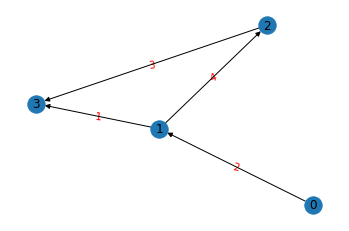

In [27]:
G.remove_edge(0,2)

nx.draw_networkx_edge_labels(G,pos,edge_labels={(0,1):'2',(1,2):'4',(1,3):'1',
(2,3):'3'},font_color='red')

nx.draw(G, pos, with_labels = True)

**Problem**: suppose you can allocate a capacity 4 (that can be distributed on several links). Where do you allocate it?

**Solution**: first compute the capacity of the cuts:
- $U=\{0,1,2\},U^C=\{3\}$ -> $C_U = 4$
- $U=\{0,1\},U^C=\{2,3\}$ -> $C_U = 5$
- $U=\{0,2\},U^C=\{1,3\}$ -> $C_U = 5$
- $U=\{0\},U^C=\{1,2,3\}$ -> $C_U = 2$

The min-cut is $\{0\},\{1,2,3\}$, thus the capacity should be allocated on the links between these set, i.e., on $(0,1)$.

Is allocating capacity 4 on $(0,1)$ optimal? NO!

In such a case, the cut capacities become:

- $U=\{0,1,2\},U^C=\{3\}$ -> $C_U = 4$
- $U=\{0,1\},U^C=\{2,3\}$ -> $C_U = 5$
- $U=\{0,2\},U^C=\{1,3\}$ -> $C_U = 5$
- $U=\{0\},U^C=\{1,2,3\}$ -> $C_U = 6$

and the corresponding throughput is 4.

Note instead that after allocating a capacity 2 on edge $(0,1)$, the cut capacities become

- $U=\{0,1,2\},U^C=\{3\}$ -> $C_U = 4$
- $U=\{0,1\},U^C=\{2,3\}$ -> $C_U = 5$
- $U=\{0,2\},U^C=\{1,3\}$ -> $C_U = 5$
- $U=\{0\},U^C=\{1,2,3\}$ -> $C_U = 4$,

with still a capacity 2 to be allocated. This remaining capacity should be allocated on both the first and the last cut, so the final solution is to allocate capacity 3 on the edge $(0,1)$, and 1 on the edge $(1,3)$ or $(2,3)$, which leads to cuts

- $U=\{0,1,2\},U^C=\{3\}$ -> $C_U = 5$
- $U=\{0,1\},U^C=\{2,3\}$ -> $C_U = 5$
- $U=\{0,2\},U^C=\{1,3\}$ -> $C_U = 5$
- $U=\{0\},U^C=\{1,2,3\}$ -> $C_U = 5$,

and maximal throughput 5.

### Practical example 2
In some cases, it is possible that the capacity of two min-cuts can be increased by improving only one edge.
Consider the following example:

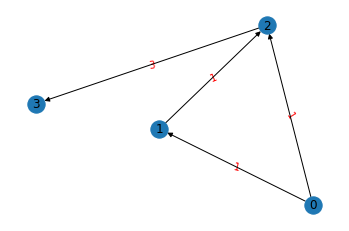

In [28]:
G.add_edge(0,2)
G.remove_edge(1,3)

nx.draw_networkx_edge_labels(G,pos,edge_labels={(0,1):'1',(0,2):'1',(1,2):'1',
(2,3):'3'},font_color='red')

nx.draw(G, pos, with_labels = True)

**Question**: what is the maximal throughput that can be send from 0 to 3?

The answer could be given by using NetworkX functions, but we do not use it now.

**Answer**: we start by computing the cut capacities:

- $U=\{0,1,2\},U^C=\{3\}$ -> $C_U = 3$
- $U=\{0,1\},U^C=\{2,3\}$ -> $C_U = 2$
- $U=\{0,2\},U^C=\{1,3\}$ -> $C_U = 4$
- $U=\{0\},U^C=\{1,2,3\}$ -> $C_U = 2$.

The maximal throughput is thus 2.

**Question 2**: suppose you can allocate a capacity 1 on the network. Where do you allocate it?

**Answer**: there are two mincuts, whose capacity is 2. 
- For the mincut $U=\{0,1\},U^C=\{2,3\}$,
$$
C_U = c(0,2) + c(1,2)
$$ 
- For the mincut $U=\{0\},U^C=\{1,2,3\}$,
$$
C_U = c(0,1) + c(0,2)
$$

Note that both the capacities can be improved by adding capacity 1 to the edge $(0,2)$. By doing this, the capacity become

- $U=\{0,1,2\},U^C=\{3\}$ -> $C_U = 3$
- $U=\{0,1\},U^C=\{2,3\}$ -> $C_U = 3$
- $U=\{0,2\},U^C=\{1,3\}$ -> $C_U = 4$
- $U=\{0\},U^C=\{1,2,3\}$ -> $C_U = 3$,

and the maximal throughput become 3.

Obviously, these type of considerations can be implemented algorithmically.

## <mark>Max Flow - Min Cut Theorem and Ford Fulkerson algorithm</mark>

**Credits**: The code for Ford-Fulkerson Algorithm is based on material that can be found on Wikipedia.

It is given a graph $G = (V, E)$ which represents a flow network, and two vertices source $s$ and sink $t$ in it. Every edge $(u,v)$ has a capacity $c(u,v)$. We want to find the maximum possible flow from $s$ to $t$ with the following constraints.

The desired flow $f$ is constructed iteratively starting from a zero-flow vector: at each round of the algorithm $f$ is updated in such a way that the capacity and balance constraints are not violated.

To do this, at each round, given the current flow vector $f$, we define the **residual network** $G_{f}(V,E_{f})$ to be the network with capacity $c_{f}(u,v)=c(u,v)-f(u,v)$. A search on the residual graph $G_f$ is performed to find an **augmenting path** (i.e., a path on the residual network with positive capacity on every edge of the path). If an augmenting path is found, this means that the current flow $f$ on that path can be increased.

### <mark>Ford–Fulkerson Algorithm</mark> 
**Inputs**: a graph $G=(V,E)$, a vector of flow capacities $c = (c(u,v))_{(u,v) \in E}$, a source node $s$, and a sink node $t$

**Output**: a flow $f = (f(u,v))_{(u,v) \in E}$ from $s$ to $t$ of maximum throughput

1. $f(u,v)\leftarrow 0$ for all edges $(u,v)$
2. While there is a path $p$ from $s$ to $t$ in $G_{f}$, such that $c_{f}(u,v)=c(u,v)-f(u,v)>0$ for all edges $(u,v)\in p$:
 1. Find $c_{f}(p)=\min\{c_{f}(u,v):(u,v)\in p\}$
 2. For each edge $(u,v)\in p:$
      1. $f(u,v)\leftarrow f(u,v)+c_{f}(p)$ (Increase the flow along the path)
      2. $f(v,u)\leftarrow f(v,u)-c_{f}(p)$ (Impose the symmetry of the flow)

Ford-Fulkerson Algorithm is called a "method", instead of "algorithm", because it does not specify univocally how to select paths.

## <mark>Example: iterative Ford-Fulkerson by hand</mark>

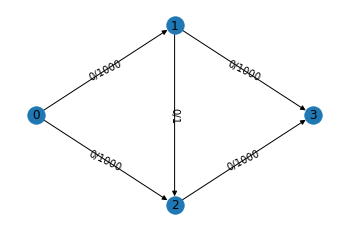

In [29]:
G = nx.DiGraph()
G.add_edges_from([(0,1),(0,2),(1,2),(1,3),(2,3)])

pos = {0: (40, 20), 1: (60, 35), 2: (60, 5), 3: (80, 20)}

labels = ['0/1000','0/1000','0/1','0/1000','0/1000']

zip_operator = zip(G.edges(), labels)
labels = dict(zip_operator)

nx.draw_networkx_edge_labels(G,pos,edge_labels = labels)

nx.draw(G, pos, with_labels = True)

We aim at finding the maximal flow from 0 to 3.

The edge labels show the flow running along the edges and the capacity of the edges.

We start with flow 0 on every path.

0-1-2-3, 0-1-3 and 0-2-3 are augmenting paths

We arbitrarly choose to add flow on 0-1-2-3.

The capacity of 0-1-2-3 is the minimal capacity of the edges in the path, which is 1.

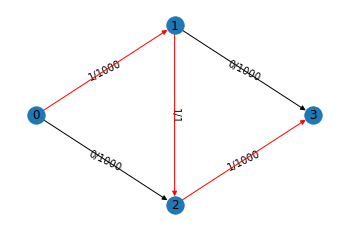

In [30]:
labels = ['1/1000','0/1000','1/1','0/1000','1/1000']

colors = ['red','black','red','black','red']

zip_operator = zip(G.edges(), labels)
labels = dict(zip_operator)

nx.draw_networkx_edge_labels(G,pos,edge_labels = labels)

nx.draw(G, pos, with_labels = True, edge_color = colors)

We update flows:
- $f(0,1) = 1$
- $f(1,0) = -1$ (symmetry)
- $f(2,3) = 1$
- $f(3,2) = -1$ (symmetry)
- $f(1,2) = 1$
- $f(2,1) = -1$ (symmetry),

and so on, and residual capacities $c_f(i,j) = c(i,j) - f(i,j)$:
- $c_f(0,1) = 1000-1 = 999$
- $c_f(1,0) = 0-(-1) = 1$
- $c_f(2,3) = 1000-1 = 999$
- $c_f(3,2) = 0-(-1) = 1$
- $c_f(1,2) = 1-1 = 0$
- $c_f(2,1) = 0-(-1) = 1$.

Note that edges $(1,0)$ and $(2,1)$, which are not in the original network, have now positive residual capacity, meaning that we can allocate some flow on them. Intuitively speaking, by symmetry constraint, allocating some flow on $(2,1)$ means removing flow from $(1,2)$.

We now proceed to iteratively updating flows. There are three augmenting paths: 0-1-3, 0-2-3, 0-2-1-3.

We arbitrarly choose to allocate flow on the path 0-2-1-3.

The maximum flow that can be allocated is 1, because of the residual capacity constraint of edge  (2,1) .

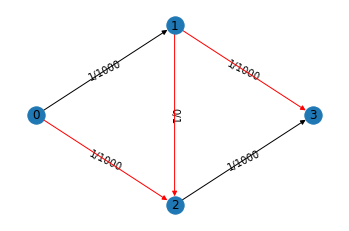

In [31]:
labels = ['1/1000','1/1000','0/1','1/1000','1/1000']

colors = ['black','red','red','red','black']

zip_operator = zip(G.edges(), labels)
labels = dict(zip_operator)

nx.draw_networkx_edge_labels(G,pos,edge_labels = labels)

nx.draw(G, pos, with_labels = True, edge_color = colors)

After 1998 steps more...

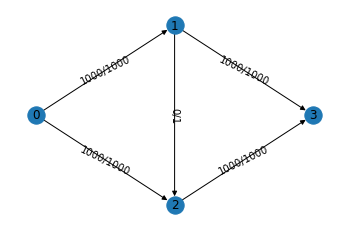

In [32]:
labels = ['1000/1000','1000/1000','0/1','1000/1000','1000/1000']

zip_operator = zip(G.edges(), labels)
labels = dict(zip_operator)

nx.draw_networkx_edge_labels(G,pos,edge_labels = labels)

nx.draw(G, pos, with_labels = True)

There are no longer augmenting paths with residual capacity in the network.

Thus, the resulting flows correspond to the maximal flow that can be send from 0 to 3.

The maximal throughput that can be send from 0 to 3 is 2000. We can verify this by using NetworkX methods.

In [33]:
# assign feature 'capacity' to every edge, and use networkX method for maximum flow

G[0][1]['capacity'] = 1000
G[0][2]['capacity'] = 1000
G[1][2]['capacity'] = 1
G[1][3]['capacity'] = 1000
G[2][3]['capacity'] = 1000

nx.algorithms.flow.maximum_flow(G,0,3)

(2000, {0: {1: 1000, 2: 1000}, 1: {2: 0, 3: 1000}, 2: {3: 1000}, 3: {}})

As you have seen, the convergence of the Ford-Fulkerson algorithm may be slow. This depends crucially on the sequence of augmenting paths that we choose. However, the algorithm is guaranteed to converge in finite steps if the capacities are rational numbers.

We draw the initial graph.

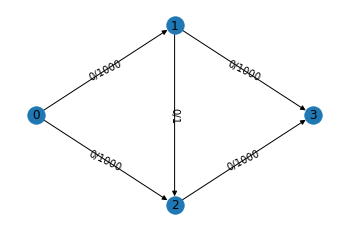

In [34]:
G = nx.DiGraph()
G.add_edges_from([(0,1),(0,2),(1,2),(1,3),(2,3)])

pos = {0: (40, 20), 1: (60, 35), 2: (60, 5), 3: (80, 20)}

labels = ['0/1000','0/1000','0/1','0/1000','0/1000']

zip_operator = zip(G.edges(), labels)
labels = dict(zip_operator)

nx.draw_networkx_edge_labels(G,pos,edge_labels = labels)

nx.draw(G, pos, with_labels = True)

Let us use another sequence of augmenting paths.

We start allocating flow on the path 0-1-3, with residual capacity equal to 1000.

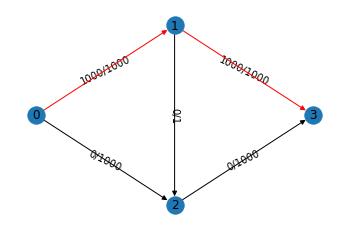

In [35]:
labels = ['1000/1000','0/1000','0/1','1000/1000','0/1000']

colors = ['red','black','black','red','black']

zip_operator = zip(G.edges(), labels)
labels = dict(zip_operator)

nx.draw_networkx_edge_labels(G,pos,edge_labels = labels)

nx.draw(G, pos, with_labels = True, edge_color = colors)

There is now only an augmenting path, which is 0-2-3, with residual capacity equal to 1000

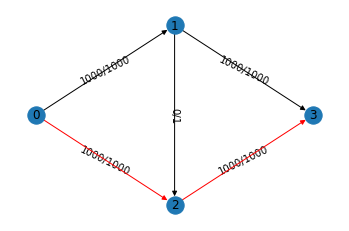

In [36]:
labels = ['1000/1000','1000/1000','0/1','1000/1000','1000/1000']

colors = ['black','red','black','black','red']

zip_operator = zip(G.edges(), labels)
labels = dict(zip_operator)

nx.draw_networkx_edge_labels(G,pos,edge_labels = labels)

nx.draw(G, pos, with_labels = True, edge_color = colors)

There are not augmenting paths in the network, thus we have found the maximal flow in only 2 steps.

### <mark>Edmonds-Karp Algorithm</mark>
The Edmonds–Karp algorithm is an implementation of Ford–Fulkerson method, where the search order to find augmenting paths is defined. A shortest path that has available capacity is found by a breadth-first search.

In [37]:
import collections

# This class represents a directed graph using adjacency matrix representation
class Graph:
    # __init__ is a reseved method in python classes.
    # In object oriented terminology, it is the constructor of the class.
    # We define a new class 'graph' instead of using the NetworkX package.
    def __init__(self, graph): 
        # the Graph object represents the flow network and the graph
        # attribute will be updated by the Edmonds-Karp Algorithm to 
        # represent the residual graph.
        # Entry [u][v] of graph array stores the capacity of link (u,v).
        self.graph = graph    #it represents c_f(u,v), initialized to c(u,v)
        # Number of nodes:
        self.ROW = len(graph)

    def bfs(self, s, t, parent):
        """Returns true if there is a path from source 's' to sink 't' in the
        residual graph. Also fills parent[] to store the path """
        # Mark all the vertices as not visited
        visited = [False] * (self.ROW)

        # Create a double-ended queue for BFS
        queue = collections.deque()

        # Mark the source node as visited and enqueue it
        # When visited, nodes are appended "to the right end" of the queue.
        queue.append(s)
        visited[s] = True

        # Standard BFS loop
        while queue: # while there are still elements in the queue
            # Nodes are extracted from "the left end" of the queue
            u = queue.popleft()

            # Get all adjacent vertices of the dequeued vertex u
            # If an adjacent vertex has not been visited, then mark 
            # it as visited and enqueue it.
            
            # Enumerate() method adds a counter to an iterable
            # to keep a count of iterations. We cycle over row
            # u of graph array: ind is the index of the node,
            # val is >0 if node ind is adjacent to u, i.e. if 
            # there is residual capacity c_f on the link (u,ind),  
            # it is 0 otherwise.
            for ind, val in enumerate(self.graph[u]):
                if (visited[ind] == False) and (val > 0):
                    queue.append(ind)
                    visited[ind] = True
                    parent[ind] = u

        # If sink is reached by BFS starting from source, then return
        # true, else return false
        return visited[t]

    # Returns the maximum flow from s to t in the given graph
    def edmonds_karp(self, source, sink):
        # parent array is filled by bfs() and it is used 
        # to compute augmenting paths.
        # It is initialized with the sentinel value -1
        parent = [-1] * (self.ROW)

        # Both max flow value and max flow vector are 
        # initialized to 0
        max_flow = 0  
        # initialize matrix of zeros with size ROW x ROW
        flow = np.array([[0] * (self.ROW)] * (self.ROW))

        # Augment the flow while there is a path from source to sink
        # in the residual graph
        while self.bfs(source, sink, parent): # the algorithm stops when there no are augmenting paths from s to t
            # now parent stores the augmenting path found by bfs

            # Find the minimum residual capacity of the edges along the
            # origin-destination path found by BFS.
            res_capacity = float("Inf")
            # start from the endpoint of the path
            n = sink
            # travel the path backwards until you reach the source
            # and update the minimal residual capacity of links
            while n != source:
                res_capacity = min(res_capacity, self.graph[parent[n]][n])
                n = parent[n] 

            # Add the residual capacity to the maximal throughput
            max_flow += res_capacity

            # Update the flow vector by adding the residual capacity
            # of the augmenting path to each edge in the path (to preserve
            # symmetry, subtract it to each reverse edge).
            # Compute the new residual network by updating
            # the residual capacities c_f of the edges and reverse edges
            # along the augmenting path.
            v = sink
            while v != source:
                u = parent[v]
                flow[u][v] += res_capacity
                flow[v][u] -= res_capacity
                self.graph[u][v] -= res_capacity  #c_f updated subtracting flow
                self.graph[v][u] += res_capacity  #c_f updated subtracting flow
                v = parent[v]  
            
        return max_flow, flow

In [38]:
W = np.array([[0,1000,1000,0],[0,0,1,1000],[0,0,0,1000],[0,0,0,0]]) #matrix with capacities.
G = Graph(W)

max_flow, flow = Graph.edmonds_karp(G,0,3) #G: istance of class 'Graph', 0: source, 3: sink

print("The maximum flow:", max_flow, "\n")
print("The flow distribution: \n", flow)

The maximum flow: 2000 

The flow distribution: 
 [[    0  1000  1000     0]
 [-1000     0     0  1000]
 [-1000     0     0  1000]
 [    0 -1000 -1000     0]]


Let us explore the steps of the algorithm by adding some print in the code.

In [39]:
class Graph_print:
    # __init__ is a reseved method in python classes.
    # In object oriented terminology, it is the constructor of the class.
    # We define a new class 'graph' instead of using the NetworkX package.
    def __init__(self, graph): 
        # the Graph object represents the flow network and the graph
        # attribute will be updated by the Edmonds-Karp Algorithm to 
        # represent the residual graph.
        # Entry [u][v] of graph array stores the capacity of link (u,v).
        self.graph = graph  
        # Number of nodes:
        self.ROW = len(graph)

    def bfs(self, s, t, parent):
        """Returns true if there is a path from source 's' to sink 't' in the
        residual graph. Also fills parent[] to store the path """
        # Mark all the vertices as not visited
        visited = [False] * (self.ROW)

        # Create a double-ended queue for BFS
        queue = collections.deque()

        # Mark the source node as visited and enqueue it
        # When visited, nodes are appended "to the right end" of the queue.
        queue.append(s)
        visited[s] = True

        # Standard BFS loop
        while queue: # while there are still elements in the queue
            # Nodes are extracted from "the left end" of the queue
            print("Queue:", queue, "\n")
            u = queue.popleft()
            print("Extracted node:", u, "\n")

            # Get all adjacent vertices of the dequeued vertex u
            # If an adjacent vertex has not been visited, then mark 
            # it as visited and enqueue it.
            
            # Enumerate() method adds a counter to an iterable
            # to keep a count of iterations. We cycle over row
            # u of graph array: ind is the index of the node,
            # val is >0 if node ind is adjacent to u, i.e. if 
            # there is residual capacity on the link (u,ind),
            # it is 0 otherwise.
            for ind, val in enumerate(self.graph[u]): 
                if (visited[ind] == False) and (val > 0):
                    queue.append(ind)
                    visited[ind] = True
                    parent[ind] = u
            
            print("Parents", parent, "\n")
            print("Visited", visited, "\n \n \n")

        # If sink is reached by BFS starting from source, then return
        # true, else return false
        return visited[t]

    # Returns the maximum flow from s to t in the given graph
    def edmonds_karp(self, source, sink):
        n_iter = 1
        print("iteration of bfs number:", n_iter, "\n")
        # parent array is filled by bfs() and it is used 
        # to compute augmenting paths.
        # It is initialized with the sentinel value -1
        # If parent[j] == -1, node 'j' has not been visited yet
        parent = [-1] * (self.ROW)

        # Both max flow value and max flow vector are 
        # initialized to 0
        max_flow = 0  
        # initialize matrix of zeros with size ROW x ROW
        flow = np.array([[0] * (self.ROW)] * (self.ROW))

        # Augment the flow while there is a path from source to sink
        # in the residual graph
        while self.bfs(source, sink, parent): # the algorithm stops when there are augmenting paths from s to t
            # now parent stores the augmenting path found by bfs

            # Find the minimum residual capacity of the edges along the
            # origin-destination path found by BFS.
            res_capacity = float("Inf")
            # start from the endpoint of the path
            n = sink
            # travel the path backwards until you reach the source
            # and update the minimal residual capacity of links
            while n != source:
                res_capacity = min(res_capacity, self.graph[parent[n]][n])
                n = parent[n] 

            # Add the residual capacity to the maximal throughput
            max_flow += res_capacity

            # Update the flow vector by adding the residual capacity
            # of the augmenting path to each edge in the path (to preserve
            # symmetry, subtract it to each reverse edge).
            # Compute the new residual network by updating
            # the residual capacities of the edges and reverse edges
            # along the augmenting path.
            v = sink
            while v != source:
                u = parent[v]
                flow[u][v] += res_capacity
                flow[v][u] -= res_capacity
                self.graph[u][v] -= res_capacity
                self.graph[v][u] += res_capacity
                v = parent[v]  
            n_iter += 1
            print("iteration of bfs number:", n_iter, "\n")
            
        return max_flow, flow

In [40]:
W = np.array([[0,1000,1000,0],[0,0,1,1000],[0,0,0,1000],[0,0,0,0]])
G = Graph_print(W)

max_flow, flow = Graph_print.edmonds_karp(G,0,3)

iteration of bfs number: 1 

Queue: deque([0]) 

Extracted node: 0 

Parents [-1, 0, 0, -1] 

Visited [True, True, True, False] 
 
 

Queue: deque([1, 2]) 

Extracted node: 1 

Parents [-1, 0, 0, 1] 

Visited [True, True, True, True] 
 
 

Queue: deque([2, 3]) 

Extracted node: 2 

Parents [-1, 0, 0, 1] 

Visited [True, True, True, True] 
 
 

Queue: deque([3]) 

Extracted node: 3 

Parents [-1, 0, 0, 1] 

Visited [True, True, True, True] 
 
 

iteration of bfs number: 2 

Queue: deque([0]) 

Extracted node: 0 

Parents [-1, 0, 0, 1] 

Visited [True, False, True, False] 
 
 

Queue: deque([2]) 

Extracted node: 2 

Parents [-1, 0, 0, 2] 

Visited [True, False, True, True] 
 
 

Queue: deque([3]) 

Extracted node: 3 

Parents [-1, 3, 0, 2] 

Visited [True, True, True, True] 
 
 

Queue: deque([1]) 

Extracted node: 1 

Parents [-1, 3, 0, 2] 

Visited [True, True, True, True] 
 
 

iteration of bfs number: 3 

Queue: deque([0]) 

Extracted node: 0 

Parents [-1, 3, 0, 2] 

Visited [True,

Networkx implements the Edmonds-Karp algorithm. 

The `networkx.algorithms.flow.edmonds_karp` function returns the residual network resulting $R$ after computing the maximum flow.    
The residual network $R$ from an input graph G has the same nodes as G. R is a DiGraph that contains a pair of edges (u, v) and (v, u) iff (u, v) is not a self-loop, and at least one of (u, v) and (v, u) exists in G.    
For each edge (u, v) in R, R[u][v]['capacity'] is equal to the capacity of (u, v) in G if it exists in G or zero otherwise. If the capacity is infinite, R[u][v]['capacity'] will have a high arbitrary finite value that does not affect the solution of the problem. This value is stored in R.graph['inf']. For each edge (u, v) in R, R[u][v]['flow'] represents the flow function of (u, v) and satisfies R[u][v]['flow'] == -R[v][u]['flow'].
The flow value, defined as the total flow into t, the sink, is stored in R.graph['flow_value']. If cutoff is not specified, reachability to t using only edges (u, v) such that R[u][v]['flow'] < R[u][v]['capacity'] induces a minimum s-t cut.

Networkx also provides the functions `networkx.algorithms.flow.maximum_flow` and `networkx.algorithms.flow.minimum_cut` which compute the maximun throughput and  the value and the node partition of a minimum cut, respectively.

### Exercise
1. Construct the graph of the example above, and assume the link capacities defined therein.
2. Apply the above implementation of the Edmonds-Karp algorithm to find the maximum throughput between the origin and destination nodes.
3. Compare the result to the flow found with `maximum_flow` and check that it is equal to the min-cut capacity of the graph found with `minimum_cut`.

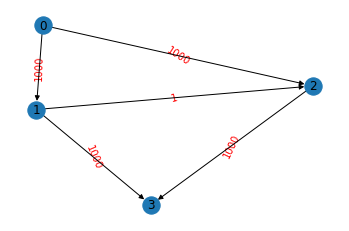

In [41]:
G = nx.DiGraph()
G.add_edges_from([(0,1),(0,2),(1,2),(1,3),(2,3)])

pos = nx.spring_layout(G)

nx.draw_networkx_edge_labels(G,pos,edge_labels={(0,1):'1000',
(0,2):'1000',(1,2):'1',(1,3):'1000',
(2,3):'1000'},font_color='red')

nx.draw(G, pos, with_labels = True)

G[0][1]['capacity'] = 1000
G[0][2]['capacity'] = 1000
G[1][2]['capacity'] = 1
G[1][3]['capacity'] = 1000
G[2][3]['capacity'] = 1000

In [42]:
W = np.array([[0,1000,1000,0],[0,0,1,1000],[0,0,0,1000],[0,0,0,0]]) #matrix with capacities.
GG = Graph(W) #istance of class 'Graph'

In [43]:
#Edmonds-Karp alg with above implementation.
max_flow, flow = Graph.edmonds_karp(GG,0,3) #G: istance of class 'Graph', 0: source, 3: sink

print("The maximum flow:", max_flow, "\n")
print("The flow distribution: \n", flow)

The maximum flow: 2000 

The flow distribution: 
 [[    0  1000  1000     0]
 [-1000     0     0  1000]
 [-1000     0     0  1000]
 [    0 -1000 -1000     0]]


In [44]:
#Edmond-Karp alg from networkx.
R = nx.algorithms.flow.edmonds_karp(G,0,3)
flow = np.array([[0] * (len(R))] * (len(R)))
for i in range(0, len(R)):
    for j in range(0, len(R)):
        try:
            flow[i][j] = R[i][j]['flow']
        except KeyError:
            flow[i][j] = 0
            
print("The maximum flow:", R.graph['flow_value'], "\n")
print("The flow distribution: \n", flow)

The maximum flow: 2000 

The flow distribution: 
 [[    0  1000  1000     0]
 [-1000     0     0  1000]
 [-1000     0     0  1000]
 [    0 -1000 -1000     0]]


In [45]:
#nx.algorithms.flow.maximum_flow
print("The maximum flow:", nx.algorithms.flow.maximum_flow(G,0,3)[0], "\n")
print("The flow distribution: \n", nx.algorithms.flow.maximum_flow(G,0,3)[1])

The maximum flow: 2000 

The flow distribution: 
 {0: {1: 1000, 2: 1000}, 1: {2: 0, 3: 1000}, 2: {3: 1000}, 3: {}}


In [46]:
#networkx.algorithms.flow.minimum_cut
print("The min-cut capacity:", nx.algorithms.flow.minimum_cut(G,0,3)[0], "\n")
print("The min-cut: \n", nx.algorithms.flow.minimum_cut(G,0,3)[1])

The min-cut capacity: 2000 

The min-cut: 
 ({0, 1, 2}, {3})


### Exercise speed of convergence Bonacich - official solution

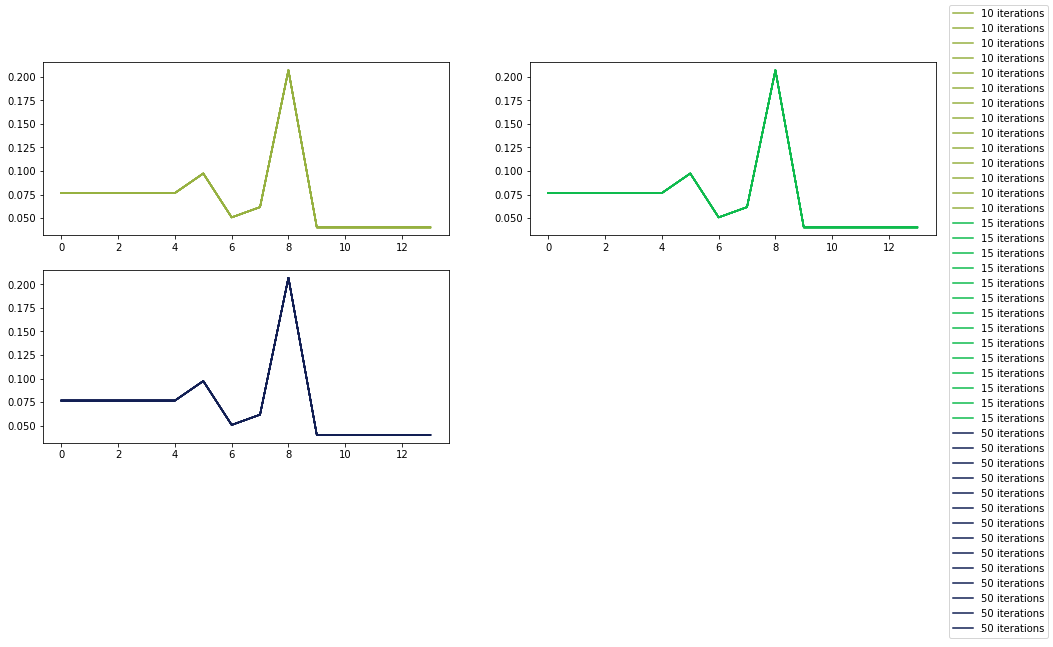

In [47]:
fig = plt.figure(1, figsize=(16,7))

# set 3 iteration numbers
iters = [10,15,50]
# define the position of the next plot in the subplot grid
position = 1
# create a list to collect the page rank values obtained in the three runs 
prvals = []

for max_iter in iters:
    # compute page rank
    z_0 = np.ones((N,1))/N
    z_old = z_0
    
    while True:
        z_new = P.T @ z_old * (1-beta) + beta * mu
        if np.linalg.norm(z_new-z_old) < tol:
            break
        z_old=z_new

    pr = z_new

    # normalize the centrality
    prval = pr / sum(pr)
    
    # append the result to the list
    prvals.append(np.array(prval)) 
    # create a new sublot in the grid
    ax = fig.add_subplot(2,2,position)
    # plot the PR values
    ax.plot(prval, color=np.random.rand(3), label='{0:d} iterations'.format(max_iter))
    position+=1

# add a legend which contains all label
# informations specified in previous plot calls
fig.legend()